In [23]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime

###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [24]:
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re

tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
    tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', 'USRTOK', tweet) # mention
    tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [25]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


461280


#### Positive Tweets

In [26]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()]
len(smile_tweet)

829183

In [27]:
# size filter
max_length = 60

sad_tweet = list(filter(lambda tweet: len(tweet) < max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) < max_length, smile_tweet))
print(len(smile_tweet))

460574
829162


### Build Dictionary

In [28]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 0

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [29]:
vocabulary_dict.get('URLTOK')

262317

In [63]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 0
        set_array.append(tweet_array)
    return np.array(set_array)

In [31]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(460574, 60)
(829162, 60)


In [32]:
smile_array[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 18, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [33]:
sad_array[0]

array([329, 412,  73, 196,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [34]:
total_tweets = np.concatenate((smile_array[:460574], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(460574), np.ones(460574)), axis=0)

## Prepare Training + Testing Data

In [35]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 0.,  1.,  0., ...,  0.,  1.,  1.])

# Load Pretrain Word2Vec Model (#DIM 52)

In [85]:
import pickle

# Load pre train Word2vec
wb_matrix = np.load("data/embedding/en_word2vec_52.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embedding/vocabulary_dict_52.pickle", "rb"))
print(len(vocabulary_dict))

(6140853, 52)
423299


In [37]:
print(vocabulary_dict.get('pairing'))
print(vocabulary_dict_.get('pairing'))

15141
6135083


In [38]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict), wb_matrix.shape[1]))
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    idx = vocabulary_dict_.get(word)
#     print(idx)
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]
        
initW.shape

(423299, 52)

In [39]:
del wb_matrix, vocabulary_dict_

# Distance Supervised Learning

In [95]:
n_input = max_length
n_output = 2
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 50
batch_size = 2048

In [96]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 27, 1, 200)


In [94]:
# with tf.Session() as sess:
#     show_graph(tf.get_default_graph().as_graph_def())
#     # Initialize all variables
#     sess.run(tf.local_variables_initializer())
#     sess.run(tf.global_variables_initializer())
    
#     sess.run(word2vec.assign(initW))# Assign the pretrain word2vec


In [97]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

In [98]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for _ in range(epochs_num):
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        
    distance_supervised_embeddings = sess.run(word2vec)
    

449


## Distance Supervised Learning Comparsion

In [126]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [102]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


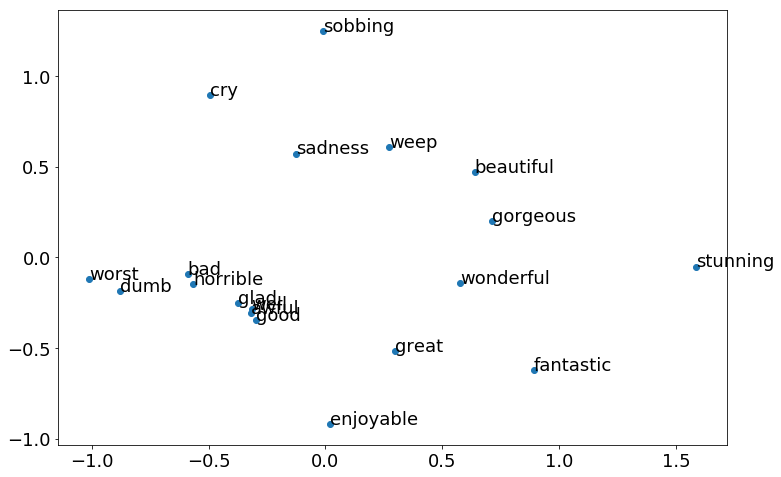

After


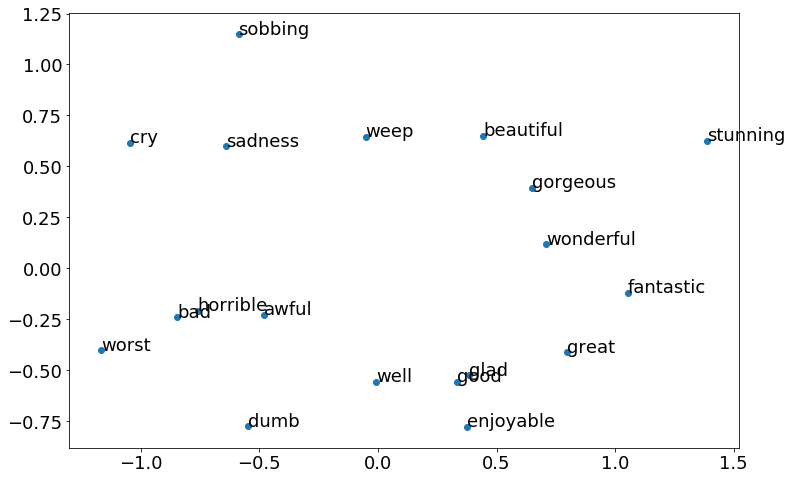

In [127]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict_)
print("After")
draw_plot(words, distance_supervised_embeddings, vocabulary_dict)

### Dump model

In [104]:
np.save('data/embedding/distance_supervised_800K', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_800K.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

# Supervised Learning

In [55]:
def polarity2label(polarity):
    if polarity =='negative':  return 0
    elif polarity =='neutral': return 1
    elif polarity =='positive':return 2 

In [56]:
# Load Training data
en_train = pd.read_csv('data/supervised_phase/en_full/en_full.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_train.head()

# Load Testing data
en_test = pd.read_csv('data/supervised_phase/en_full/en_test.tsv', delimiter='\t', names=["id", "lang", "polarity", "tweet"])
en_test.head()


,id,lang,polarity,tweet
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...
2,11380,en,negative,If these runway renovations at the airport pre...
3,11381,en,neutral,If you could ask an onstage interview question...
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...


In [57]:
en_train['label'] = en_train['polarity'].map(polarity2label)
en_train.head()

en_test['label'] = en_test['polarity'].map(polarity2label)
en_test.head()

,id,lang,polarity,tweet,label
0,11378,en,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",1
1,11379,en,neutral,Order Go Set a Watchman in store or through ou...,1
2,11380,en,negative,If these runway renovations at the airport pre...,0
3,11381,en,neutral,If you could ask an onstage interview question...,1
4,11382,en,positive,A portion of book sales from our Harper Lee/Go...,2


In [61]:
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


In [72]:

tweets_train = word_transform(train_tweet, max_length = max_length)
print(train_array.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(test_array.shape)

senti_train = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()

(18044, 60)
(20632, 60)


### Build Model

In [128]:
n_input = max_length
n_output = 3
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 500
batch_size = 2048

In [142]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [143]:
# prepare the training batch
train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
train_next_batch = train_iterator.get_next()

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-17 22:06:45 -    1 epoch, loss:1.042, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-17 22:06:48 -   11 epoch, loss:1.012, train accuracy:0.481, train f1 score:0.323, test f1 score:0.183
2017-11-17 22:06:52 -   21 epoch, loss:0.989, train accuracy:0.526, train f1 score:0.378, test f1 score:0.201
2017-11-17 22:06:55 -   31 epoch, loss:1.000, train accuracy:0.524, train f1 score:0.461, test f1 score:0.535
2017-11-17 22:06:58 -   41 epoch, loss:0.905, train accuracy:0.641, train f1 score:0.587, test f1 score:0.549
2017-11-17 22:07:02 -   51 epoch, loss:0.906, train accuracy:0.635, train f1 score:0.592, test f1 score:0.547
2017-11-17 22:07:05 -   61 epoch, loss:0.880, train accuracy:0.670, train f1 score:0.653, test f1 score:0.582
2017-11-17 22:07:08 -   71 epoch, loss:0.919, train accuracy:0.621, train f1 score:0.612, test f1 score:0.555
2017-11-17 22:07:12 -   81 epoch, loss:0.902, train accuracy:0.648, train f1 score:0.612, test f1 score:0.439
2017-11-17

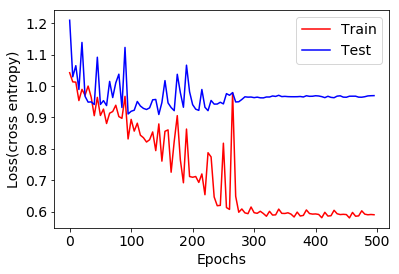

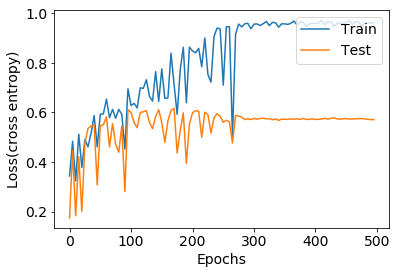

In [140]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()

    

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-11-17 22:17:43 -    1 epoch, loss:1.042, train accuracy:0.509, train f1 score:0.344, test f1 score:0.174
2017-11-17 22:17:48 -   11 epoch, loss:1.013, train accuracy:0.478, train f1 score:0.314, test f1 score:0.177
2017-11-17 22:17:52 -   21 epoch, loss:0.997, train accuracy:0.523, train f1 score:0.369, test f1 score:0.191
2017-11-17 22:17:56 -   31 epoch, loss:0.982, train accuracy:0.552, train f1 score:0.489, test f1 score:0.551
2017-11-17 22:18:01 -   41 epoch, loss:0.895, train accuracy:0.653, train f1 score:0.598, test f1 score:0.560
2017-11-17 22:18:05 -   51 epoch, loss:0.865, train accuracy:0.685, train f1 score:0.635, test f1 score:0.561
2017-11-17 22:18:09 -   61 epoch, loss:0.863, train accuracy:0.679, train f1 score:0.645, test f1 score:0.584
2017-11-17 22:18:14 -   71 epoch, loss:0.905, train accuracy:0.636, train f1 score:0.621, test f1 score:0.559
2017-11-17 22:18:18 -   81 epoch, loss:0.883, train accuracy:0.660, train f1 score:0.627, test f1 score:0.477
2017-11-17

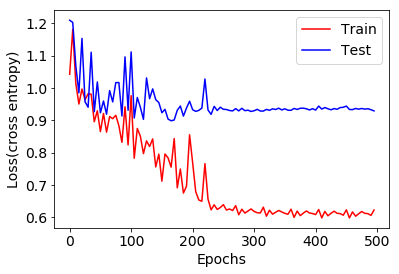

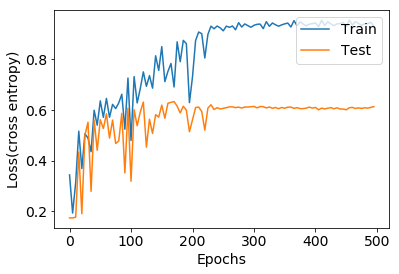

In [144]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 5)
saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train
        if epochs % 5 ==0:
            loss, pred, acc = sess.run([cross_entropy,predicted_class,accuracy], feed_dict={X:train, y:label})
            t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_test, y:senti_test})
            train_loss.append(loss)
            test_loss.append(t_loss)
            train_f1.append(f1_score(label, pred, average='weighted'))
            test_f1.append(f1_score(senti_test, t_pred, average='weighted'))
        if epochs % 10 ==0:
            print("{} - {:4d} epoch, loss:{:.3f}, train accuracy:{:.3f}, train f1 score:{:.3f}, test f1 score:{:.3f}".format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                epochs+1,
                loss, 
                acc,
                f1_score(label, pred, average='weighted'),
                f1_score(senti_test, t_pred, average='weighted')
                )
            )
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()

    